In [1]:
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)

import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [2]:
from scipy.stats import norm
from scipy.integrate import quad
from scipy.stats import gamma as gamma_pdf
from scipy.stats import norm

from jax.scipy.special import gamma, gammaincc
from jax.scipy.integrate import trapezoid

In [3]:
import sys
sys.path.insert(0, '/home/storage/hans/jax_reco_new/')
from lib.plotting import adjust_plot_1d

In [55]:
@jax.jit
def biweight_gamma_prob(x, a, b, s):  
    g_a = gamma(a)
    g_1pa = gamma(1+a)
    g_2pa = gamma(2+a)
    g_4pa = gamma(4+a)

    gincc_a = gammaincc(a, b*(s+x)) * g_a
    gincc_1pa = gammaincc(1+a, b*(s+x))*gamma(1+a)
    gincc_2pa = gammaincc(2+a, b*(s+x))*gamma(2+a)
    gincc_3pa = gammaincc(3+a, b*(s+x))*gamma(3+a)
    gincc_4pa = gammaincc(4+a, b*(s+x))*gamma(4+a)

    gincc_a_m = gammaincc(a, b*(x-s)) * g_a
    gincc_1pa_m = gammaincc(1+a, b*(x-s))*gamma(1+a)
    gincc_2pa_m = gammaincc(2+a, b*(x-s))*gamma(2+a)
    gincc_3pa_m = gammaincc(3+a, b*(x-s))*gamma(3+a)
    gincc_4pa_m = gammaincc(4+a, b*(x-s))*gamma(4+a)

    fbx = 4*b*x
    t0 = b**4 * (s**4 - 2*s**2*x**2 + x**4)
    t1 = 4*b**3 * (s**2*x - x**3)
    t2 = b**2 * (6*x**2 - 2*s**2)
    
    # branch 0 (-s < t < +s)
    tsum0 = (
                (g_a - gincc_a) * t0 
                + (g_1pa - gincc_1pa) * t1
                + (g_2pa - gincc_2pa) * t2
                + g_4pa - gincc_4pa
                + gincc_3pa * fbx
                - g_2pa * (2*fbx + a*fbx)
    )
    
    # branch 1 ( t >= +s)
    tsum1 = (
                (gincc_a_m - gincc_a) * t0
                + (gincc_1pa_m - gincc_1pa) * t1
                + (gincc_2pa_m - gincc_2pa) * t2
                + (gincc_3pa - gincc_3pa_m) * fbx
                + gincc_4pa_m - gincc_4pa         
    )

    # combine branches
    tsum = jnp.where(x < s, tsum0, tsum1)
    
    pre_fac = 15.0/(16*b**4*s**5*g_a)
    return pre_fac * tsum

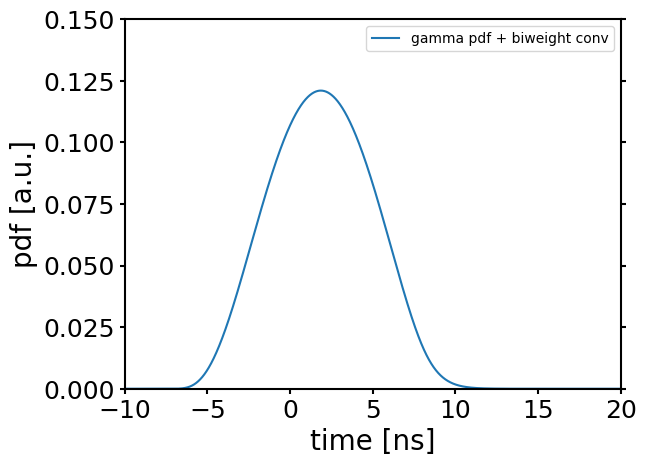

In [56]:
a = 3.75
b = 2.0
sigma = 3.0

xvals = np.linspace(-10, 30, 10000)
yvals_biweight_conv_gamma = biweight_gamma_prob(xvals, a, b, 2.5*sigma)
fig, ax = plt.subplots()

ax.plot(xvals, yvals_biweight_conv_gamma, label='gamma pdf + biweight conv')

plot_args = {'xlabel':'time [ns]', 
                 'ylabel':'pdf [a.u.]', 
                 'xlim':[-10, 20], 
                 'ylim':[0.0, 0.15]}

adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.show()

In [51]:
def biweight_gamma_cdf_numeric(x, a, b, s):
    xvals = np.linspace(-s, x, 10000)
    yvals = biweight_gamma_prob(xvals, a, b, s)
    return trapezoid(yvals, x=xvals)

In [75]:
print(biweight_gamma_cdf_numeric(10.0, a, b, 2.5*sigma))

0.9987885726316894


In [58]:
%timeit biweight_gamma_prob(0.0, a, b, 2.5*sigma).block_until_ready()

1.82 ms ± 179 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [108]:
def biweight_gamma_cdf(x, a, b, s):
    g_a = gamma(a)
    bspx = b * (s+x)
    bspx_pa = jnp.power(bspx ,a)
    exp_bspx = jnp.exp(bspx)
    g_a_bspx = g_a * gammaincc(a, bspx)
    bxms = b * (x-s)
    g_a_bxms = g_a * gammaincc(a, bxms)
    bx = b*x

    # branch 0 x < s
    pre_factor = 1./(16.*b**5*s**5*(s+x)*g_a) * jnp.exp(-bspx)

    c__11 = (
        3*(1 + a)*(2 + a)*(3 + a)*(4 + a)*x
        + 3*(2 + a)*(3 + a)*bspx*((4 + a)*s - (1 + 4*a)*x)
        - b**3*(s + x)**2*((8 + 7*a)*s**2 - 3*(3 + 7*a)*s*x + 3*(1 + 4*a)*x**2)
        - b**2*(s + x)*((a - 1)*(16 + 7*a)*s**2 + 3*(3 + a)*(2 + 3*a)*s*x - 6*(1 + 3*a*(2 + a))*x**2)
        + b**4*(8*s**5 + 15*s**4*x - 10*s**2*x**3)
    )
    
    c1 = (
        3*b**(4 + a)*x**5*(s + x)**a
        + bspx_pa * (3*(1 + a)*(2 + a)*(3 + a)*(4 + a)*s + c__11)
    )

    c__21 = (-3*a**5 + 15*a**4*(-2 + bx)
             + b**5*(s + x)**3*(8*s**2 - 9*s*x + 3*x**2)
             + 5*a**3*(-21 + 2*b*(9*x + b*(s**2 - 3*x**2)))
             - 15*a**2*(10 + b*(-11*x + 2*b*(x**2*(3 - bx) + s**2*(-1 + bx))))
             + a*(-72 - 5*b*(3*b**3*s**4 - 18*x + 3*x*bx*(4 + bx*(-2 + bx)) 
                             + b*s**2*(-4 - 6*bx*(-1 + bx))))
    )
    
    c2 = exp_bspx*(s+x) * c__21 * (g_a - g_a_bspx)
    
    branch0 = pre_factor * (c1 + c2)

    # branch 1 x >= s:
    c__11 = (
        3*a**4 + 72*(1 + b*s) + 3*a**3*(10 + b*(s - 4*x))
        + a**2*(105 + b*(s*(27 - 7*b*s) - 9*(7 + b*s)*x + 18*b*x**2))
        + a*(150 + b*(s*(78 - b*s*(9 + 7*b*s)) + (-87 + b*s*(-33 + 14*b*s))*x + 9*b*(4 + b*s)*x**2 - 12*b**2*x**3)) 
        + b*(-18*x + b*(8*s**2 - 9*s*x + 3*x**2)*(2 + bspx*(bspx-1)))
    )

    c__12 = (
        72 + 3*a**4 - 72*b*s - 3*a**3*(-10 + b*(s + 4*x))
        + b*(-18*x + b*(2 + b*(1 - bxms)*(s - x))*(8*s**2 + 9*s*x + 3*x**2))
        + a**2*(105 + b*(-7*b*s**2 + 9*s*(-3 + bx) + 9*x*(-7 + 2*bx))) 
        + a*(150 + b*(7*b**2*s**3 + b*s**2*(-9 + 14*bx) + s*(-78 + 3*bx*(11 - 3*bx)) - 3*x*(29 + 4*bx*(-3 + bx))))
    )
    
    c1 = b**a * ((s + x)**a*c__11 - jnp.exp(2*b*s)*(x-s)**a*c__12)

    c__21 = (
        10*a*(1 + a)*(2 + a)*b*s**2 - 15*a*b**3*s**4 - 8*b**4*s**5
        + 15*(a*(1 + a)*(2 + a)*(3 + a) - 2*a*(1 + a)*b**2*s**2 + b**4*s**4)*x
        - 30*a*(2 + a*(3 + a) - b**2*s**2)*bx*x
        + 10*(3*a*(1 + a) - b**2*s**2)*bx**2*x
        - 15*a*bx**3*x
        + 3*bx**4*x
    )

    c__22 = (
        3*a**5 - 15*a**4*(-2 + bx) 
        - b**5*(s + x)**3*(8*s**2 - 9*s*x + 3*x**2)
        + 5*a**3*(21 - 2*b*(9*x + b*(s**2 - 3*x**2)))
        + 15*a**2*(10 + b*(-11*x + 2*b*(x**2*(3 - bx) + s**2*(-1 + bx))))
        + a*(72 + 5*b*(3*b**3*s**4 - 18*x + 3*bx*x*(4 + bx*(-2 + bx)) + b*s**2*(-4 - 6*bx*(-1 + bx))))    
    )

    c2 = exp_bspx * (
        16*b**5*s**5*g_a - 3*a*(1 + a)*(2 + a)*(3 + a)*(4 + a)*g_a_bxms
        + b*g_a_bxms * c__21 
        + g_a_bspx * c__22
    )
    
    branch1 = pre_factor * (c1 + c2) * (s+x)

    
    return jnp.where(x < s, branch0, branch1)

In [126]:
def biweight_gamma_cdf2(x, a, b, s):
    g_a = gamma(a)
    bspx = b * (s+x)
    bspx_pa = jnp.power(bspx ,a)
    exp_bspx = jnp.exp(bspx)
    exp_mbspx = jnp.exp(-bspx)
    g_a_bspx = g_a * gammaincc(a, bspx)
    bxms = b * (x-s)
    g_a_bxms = g_a * gammaincc(a, bxms)
    bx = b*x

    # branch 0 x < s
    pre_factor = 1./(16.*b**5*s**5*(s+x)*g_a) 

    c__11 = (
        3*(1 + a)*(2 + a)*(3 + a)*(4 + a)*x
        + 3*(2 + a)*(3 + a)*bspx*((4 + a)*s - (1 + 4*a)*x)
        - b**3*(s + x)**2*((8 + 7*a)*s**2 - 3*(3 + 7*a)*s*x + 3*(1 + 4*a)*x**2)
        - b**2*(s + x)*((a - 1)*(16 + 7*a)*s**2 + 3*(3 + a)*(2 + 3*a)*s*x - 6*(1 + 3*a*(2 + a))*x**2)
        + b**4*(8*s**5 + 15*s**4*x - 10*s**2*x**3)
    )
    
    c1 = exp_mbspx * (
        3*b**(4 + a)*x**5*(s + x)**a
        + bspx_pa * (3*(1 + a)*(2 + a)*(3 + a)*(4 + a)*s + c__11)
    )

    c__21 = (-3*a**5 + 15*a**4*(-2 + bx)
             + b**5*(s + x)**3*(8*s**2 - 9*s*x + 3*x**2)
             + 5*a**3*(-21 + 2*b*(9*x + b*(s**2 - 3*x**2)))
             - 15*a**2*(10 + b*(-11*x + 2*b*(x**2*(3 - bx) + s**2*(-1 + bx))))
             + a*(-72 - 5*b*(3*b**3*s**4 - 18*x + 3*x*bx*(4 + bx*(-2 + bx)) 
                             + b*s**2*(-4 - 6*bx*(-1 + bx))))
    )
    
    c2 = (s+x) * c__21 * (g_a - g_a_bspx)
    
    branch0 = pre_factor * (c1 + c2)

    # branch 1 x >= s:
    c__11 = (
        3*a**4 + 72*(1 + b*s) + 3*a**3*(10 + b*(s - 4*x))
        + a**2*(105 + b*(s*(27 - 7*b*s) - 9*(7 + b*s)*x + 18*b*x**2))
        + a*(150 + b*(s*(78 - b*s*(9 + 7*b*s)) + (-87 + b*s*(-33 + 14*b*s))*x + 9*b*(4 + b*s)*x**2 - 12*b**2*x**3)) 
        + b*(-18*x + b*(8*s**2 - 9*s*x + 3*x**2)*(2 + bspx*(bspx-1)))
    )

    c__12 = (
        72 + 3*a**4 - 72*b*s - 3*a**3*(-10 + b*(s + 4*x))
        + b*(-18*x + b*(2 + b*(1 - bxms)*(s - x))*(8*s**2 + 9*s*x + 3*x**2))
        + a**2*(105 + b*(-7*b*s**2 + 9*s*(-3 + bx) + 9*x*(-7 + 2*bx))) 
        + a*(150 + b*(7*b**2*s**3 + b*s**2*(-9 + 14*bx) + s*(-78 + 3*bx*(11 - 3*bx)) - 3*x*(29 + 4*bx*(-3 + bx))))
    )
    
    c1 = exp_mbspx * b**a * (jnp.power(s+x, a)*c__11 - jnp.exp(2*b*s)*jnp.power(x-s, a)*c__12)

    c__21 = (
        10*a*(1 + a)*(2 + a)*b*s**2 - 15*a*b**3*s**4 - 8*b**4*s**5
        + 15*(a*(1 + a)*(2 + a)*(3 + a) - 2*a*(1 + a)*b**2*s**2 + b**4*s**4)*x
        - 30*a*(2 + a*(3 + a) - b**2*s**2)*bx*x
        + 10*(3*a*(1 + a) - b**2*s**2)*bx**2*x
        - 15*a*bx**3*x
        + 3*bx**4*x
    )

    c__22 = (
        3*a**5 - 15*a**4*(-2 + bx) 
        - b**5*(s + x)**3*(8*s**2 - 9*s*x + 3*x**2)
        + 5*a**3*(21 - 2*b*(9*x + b*(s**2 - 3*x**2)))
        + 15*a**2*(10 + b*(-11*x + 2*b*(x**2*(3 - bx) + s**2*(-1 + bx))))
        + a*(72 + 5*b*(3*b**3*s**4 - 18*x + 3*bx*x*(4 + bx*(-2 + bx)) + b*s**2*(-4 - 6*bx*(-1 + bx))))    
    )

    c2 = (
        16*b**5*s**5*g_a - 3*a*(1 + a)*(2 + a)*(3 + a)*(4 + a)*g_a_bxms
        + b*g_a_bxms * c__21 
        + g_a_bspx * c__22
    )
    
    branch1 = pre_factor * (c1 + c2) * (s+x)

    
    return jnp.where(x < s, branch0, branch1)

In [109]:
%timeit biweight_gamma_cdf(10.0, 3.75, 2.0, 2.5 * 3.0).block_until_ready()

3.27 ms ± 102 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [111]:
print(biweight_gamma_cdf(5.0, 3.75, 2.0, 2.5 * 3.0))

(0.838081227184677+0j)


In [131]:
xvals = np.linspace(-7.0, 20.0, 100)

numeric_integrals = np.array([biweight_gamma_cdf_numeric(x, a, b, 2.5*sigma) for x in xvals])
exact_integrals = np.array([biweight_gamma_cdf2(x, a, b, 2.5*sigma) for x in xvals])

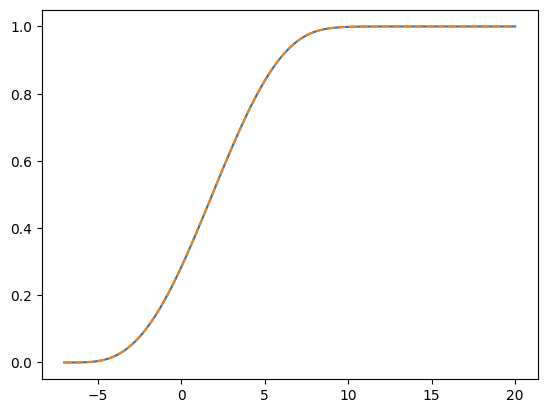

In [132]:
plt.plot(xvals, numeric_integrals)
plt.plot(xvals, exact_integrals, linestyle='dashed')

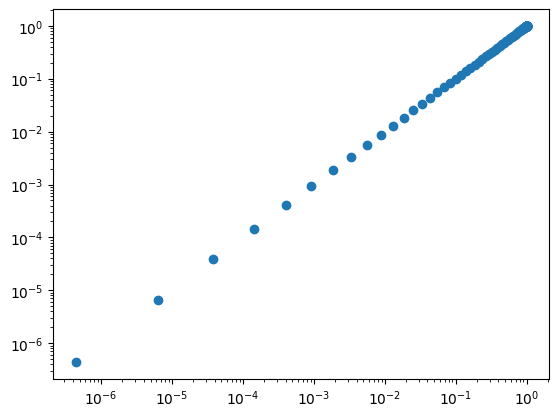

In [133]:
plt.scatter(numeric_integrals, exact_integrals)
plt.yscale('log')
plt.xscale('log')

In [134]:
np.max((numeric_integrals-exact_integrals)/exact_integrals)

2.7127524234398342e-08

In [135]:
np.min((numeric_integrals-exact_integrals)/exact_integrals)

-4.1145493463013324e-09